In [354]:
from sympy.polys.matrices import DomainMatrix
from sympy.physics.quantum.matrixutils import matrix_tensor_product
from sympy.parsing.sympy_parser import parse_expr
from sympy.combinatorics.permutations import Permutation
from sympy import Matrix, SparseMatrix, eye
import matplotlib.pyplot as plt
import numpy
import os.path
import json
import itertools
import networkx as nx
Symqt = SymmetricFunctions(QQ)
s = Symqt.s()
sp = Symqt.sp()
e = Symqt.e()
p = Symqt.p()

In [355]:
# s for when we want to work with GL_n and
# sp for when we want to work with Sp_n
rep_type = s

In [356]:
def standard_basis(n):
    # Create the standard basis for an n-dimensional vector space
    basis = []

    n = Integer(n)

    for i in range(n):
        basis_element = SparseMatrix(Matrix([0] * n))
        basis_element[i] = 1
        basis.append(basis_element)

    return basis

In [357]:
def tensor(obs):
    # Return the n-fold tensor product of some objects

    n = len(obs)

    if n == 1:
        return obs[0]

    a = obs[0]
    b = tensor(obs[1:])

    return matrix_tensor_product(a, b)

In [358]:
def direct_sum_basis(bases):
    if len(bases) == 1:
        return bases[0]

    A = bases[0]
    B = direct_sum_basis(bases[1:])

    basis = []

    for a in A:
        basis.append(a.col_join(SparseMatrix(Matrix([0] * B[0].shape[0]))))
    for b in B:
        basis.append(SparseMatrix(Matrix([0] * A[0].shape[0])).col_join(b))

    return basis

In [359]:
def tensor_basis(bases):
    if len(bases) == 1:
        return bases[0]

    basis = []

    for a in bases[0]:
        for b in tensor_basis(bases[1:]):
            basis.append(tensor([a, b]))

    return basis

In [360]:
class MinimizedRepresentation:
    def __init__(self, information):
        self.information = information

    def multiply_by(irriducible, represenation):
        new_information = {}

        for rho in represenation.information:
            for irriducible_sub_rep, multiplicty in rep_type[list(irriducible.information.keys())[0]] * rep_type[rho]:
                subspace = tensor_basis(
                    [represenation.information[rho], standard_basis(multiplicty)])

                if irriducible_sub_rep in new_information:
                    new_information[irriducible_sub_rep] = direct_sum_basis(
                        [new_information[irriducible_sub_rep], subspace])
                else:
                    new_information[irriducible_sub_rep] = subspace

        maps = {}
        dimensions = {rho: [0, len(new_information[rho])] for rho in new_information}

        for rho in represenation.information:
            for irriducible_sub_rep, multiplicty in rep_type[list(irriducible.information.keys())[0]] * rep_type[rho]:
                dimensions[irriducible_sub_rep][1] -= multiplicty

                maps[(rho, irriducible_sub_rep)] = SparseMatrix(dimensions[irriducible_sub_rep][0], multiplicty, [0] * int(dimensions[irriducible_sub_rep][0] * multiplicty)).col_join(
                    SparseMatrix(eye(multiplicty))).col_join(
                    SparseMatrix(dimensions[irriducible_sub_rep][1], multiplicty,  [0] * int(dimensions[irriducible_sub_rep][1] * multiplicty)))

                dimensions[irriducible_sub_rep][0] += multiplicty

        return MinimizedRepresentation(new_information), maps

    def num_irriducibles(self):
        return len(self.information)

In [361]:
class GradedAlgebraRepresentation:
    def __init__(self, information, max_degree):
        # The highest degree this algebra is calculated to
        self.max_degree = max_degree
        # The underlying symplectic representations sorted by degree
        self.information = information

    def ideal_generated_by(self):
        pass  # TODO: This

In [362]:
class GradedEndormorphism:
    def __init__(self, information, degree, gar):
        self.information = information
        self.degree = degree
        self.gar = gar

    def plot(self, latex, size=(10, 10)):
        def internal_label(degree, weight):
            return (f'd{degree}w' + f'{weight}'[1:-1]).replace(' ', '').replace(',', 'c')

        def external_label(weight, dimension):
            return '$V^{' + f'{dimension}' + '}_{' + f'{weight}'[1:-1] + '}$'

        G = nx.DiGraph()
        labels = {}

        h = self.gar.information[max(self.gar.information.keys())].num_irriducibles() * 1.5

        for k in self.gar.information.keys():
            for i, weight in enumerate(self.gar.information[k].information):
                G.add_node(internal_label(k, weight), pos=(
                    float((i + 1 / 2.0) * h / self.gar.information[k].num_irriducibles()), (float(k) - 1) * 2))
                labels[internal_label(k, weight)] = external_label(
                    weight, len(self.gar.information[k].information[weight]))

            if k in self.information:
                for nonzero_map in self.information[k]:
                    G.add_edge(internal_label(k, nonzero_map[0]),
                               internal_label(k + 1, nonzero_map[1]))

        plt.figure(figsize=size)
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw(G, pos, node_color='#fabfff')
        nx.draw_networkx_labels(G, pos, labels, font_size=8)

        if latex:
            print(nx.to_latex(G, pos, node_label=labels))

In [363]:
def create_tensor_representation_algebra(represenation, n):
    tensor_algebra = GradedAlgebraRepresentation({1: represenation}, 1)
    left_multiplication = GradedEndormorphism({}, 0, tensor_algebra)

    for k in range(1, n):
        tensor_algebra_information = tensor_algebra.information
        left_multiplication_information = left_multiplication.information

        tensor_algebra_information[k + 1], left_multiplication_information[k] = MinimizedRepresentation.multiply_by(
            represenation, tensor_algebra_information[k])

        tensor_algebra = GradedAlgebraRepresentation(tensor_algebra_information, k + 1)
        left_multiplication = GradedEndormorphism(
            left_multiplication_information, 1, tensor_algebra)

    return tensor_algebra, left_multiplication

In [364]:
base_representation = MinimizedRepresentation({(1, 1, 1): standard_basis(1)})
tensor_algebra, left_multiplication = create_tensor_representation_algebra(base_representation, 4)

\documentclass{report}
\usepackage{tikz}
\usepackage{subcaption}

\begin{document}
\begin{figure}
  \begin{tikzpicture}
      \draw
        (25.5, 0.0) node (d1w1c1c1){$V^{1}_{1, 1, 1}$}
        (6.375, 2.0) node (d2w1c1c1c1c1c1){$V^{1}_{1, 1, 1, 1, 1, 1}$}
        (19.125, 2.0) node (d2w2c1c1c1c1){$V^{1}_{2, 1, 1, 1, 1}$}
        (31.875, 2.0) node (d2w2c2c2){$V^{1}_{2, 2, 2}$}
        (44.625, 2.0) node (d2w2c2c1c1){$V^{1}_{2, 2, 1, 1}$}
        (2.125, 4.0) node (d3w1c1c1c1c1c1c1c1c1){$V^{1}_{1, 1, 1, 1, 1, 1, 1, 1, 1}$}
        (6.375, 4.0) node (d3w2c2c1c1c1c1c1){$V^{3}_{2, 2, 1, 1, 1, 1, 1}$}
        (10.625, 4.0) node (d3w2c1c1c1c1c1c1c1){$V^{2}_{2, 1, 1, 1, 1, 1, 1, 1}$}
        (14.875, 4.0) node (d3w2c2c2c1c1c1){$V^{4}_{2, 2, 2, 1, 1, 1}$}
        (19.125, 4.0) node (d3w3c2c1c1c1c1){$V^{2}_{3, 2, 1, 1, 1, 1}$}
        (23.375, 4.0) node (d3w2c2c2c2c1){$V^{2}_{2, 2, 2, 2, 1}$}
        (27.625, 4.0) node (d3w3c1c1c1c1c1c1){$V^{1}_{3, 1, 1, 1, 1, 1, 1}$}
        (31.875, 4.0) no

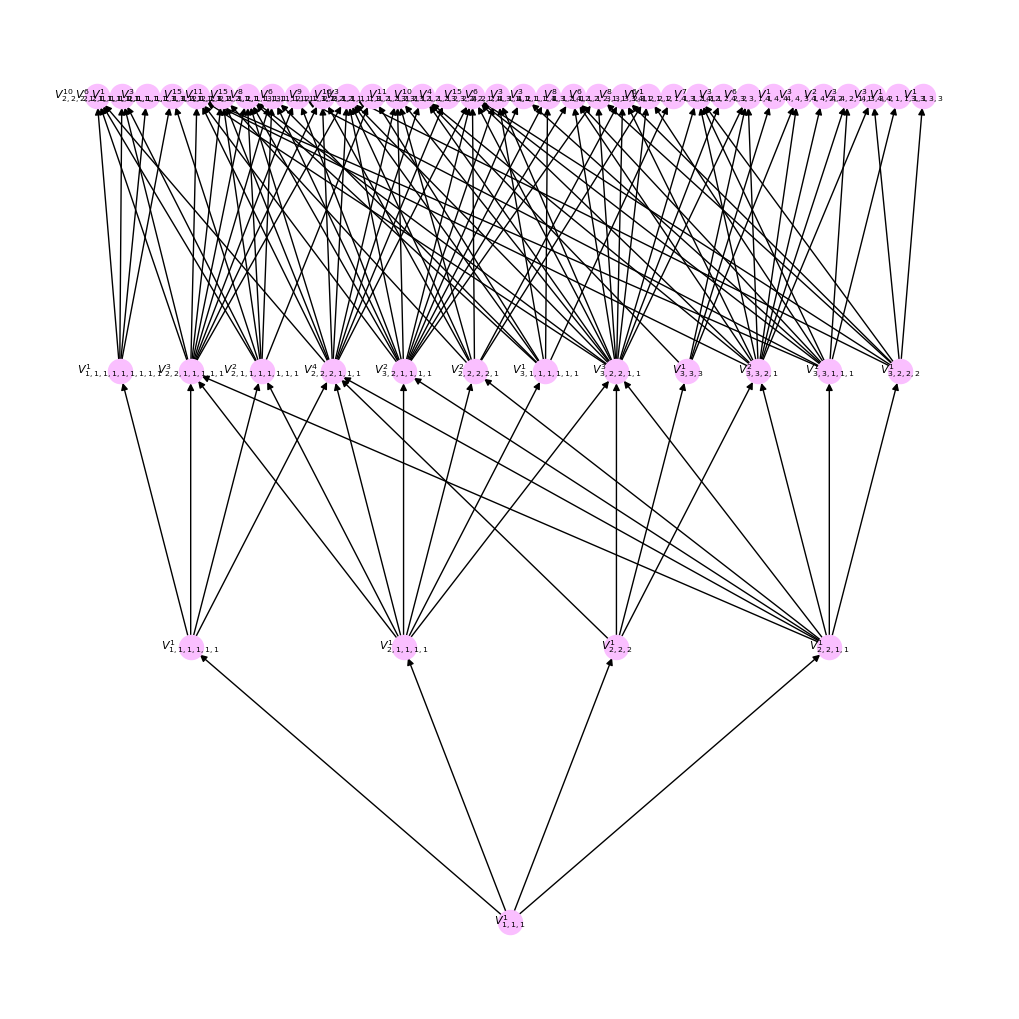

In [365]:
left_multiplication.plot(true)

In [85]:
print(tensor_algebra.information[5].information)

{[2, 1, 1, 1]: [Matrix([
[1],
[0],
[0],
[0]]), Matrix([
[0],
[1],
[0],
[0]]), Matrix([
[0],
[0],
[1],
[0]]), Matrix([
[0],
[0],
[0],
[1]])], [3, 1, 1]: [Matrix([
[1],
[0],
[0],
[0],
[0],
[0]]), Matrix([
[0],
[1],
[0],
[0],
[0],
[0]]), Matrix([
[0],
[0],
[1],
[0],
[0],
[0]]), Matrix([
[0],
[0],
[0],
[1],
[0],
[0]]), Matrix([
[0],
[0],
[0],
[0],
[1],
[0]]), Matrix([
[0],
[0],
[0],
[0],
[0],
[1]])], [2, 2, 1]: [Matrix([
[1],
[0],
[0],
[0],
[0]]), Matrix([
[0],
[1],
[0],
[0],
[0]]), Matrix([
[0],
[0],
[1],
[0],
[0]]), Matrix([
[0],
[0],
[0],
[1],
[0]]), Matrix([
[0],
[0],
[0],
[0],
[1]])], [3, 2]: [Matrix([
[1],
[0],
[0],
[0],
[0]]), Matrix([
[0],
[1],
[0],
[0],
[0]]), Matrix([
[0],
[0],
[1],
[0],
[0]]), Matrix([
[0],
[0],
[0],
[1],
[0]]), Matrix([
[0],
[0],
[0],
[0],
[1]])], [4, 1]: [Matrix([
[1],
[0],
[0],
[0]]), Matrix([
[0],
[1],
[0],
[0]]), Matrix([
[0],
[0],
[1],
[0]]), Matrix([
[0],
[0],
[0],
[1]])], [1, 1, 1, 1, 1]: [Matrix([[1]])], [5]: [Matrix([[1]])]}
